Data ophalen. Dit is een aangepaste view.

In [1]:
from pymysql import Connect
import pandas as pd
import pyodbc, psycopg2

db_conn = psycopg2.connect(database="depdatabase", user="postgres", password="DaddySzymon123", host="vichogent.be", port="40033")

cursor = db_conn.cursor()

cursor.execute(f"""
        select * from view_machine_learning_data
""")

df = pd.DataFrame(cursor.fetchall(), columns=['ondernemingsnummer', 'urban','balanstotaal','omzet', 'personeelsbestanden', 'foundingdate', 'environment','social','governance'])

In [2]:
df.head()

,ondernemingsnummer,urban,balanstotaal,omzet,personeelsbestanden,foundingdate,environment,social,governance
0,411961473,0.1904761904761904,5317456.02,12348474.46,44.0,1972-01-01,0.0,0.167493,0.612960
1,477176652,0.75,None,None,NaN,2002-03-26,0.0,0.167493,0.612960
2,421994738,0.6572222,5346109.79,0,12.0,1981-10-01,0.0,0.025496,0.014873
3,423861690,0.5333333333333333,2947305.45,0,16.0,1983-03-30,0.0,0.025496,0.300637
4,454287622,0.87777,None,None,NaN,1995-01-13,0.0,0.446884,0.311969


Null-waarden droppen

In [3]:
df = df.dropna()

In [4]:
len(df)

1919

In [5]:
df.head()

,ondernemingsnummer,urban,balanstotaal,omzet,personeelsbestanden,foundingdate,environment,social,governance
0,411961473,0.1904761904761904,5317456.02,12348474.46,44.0,1972-01-01,0.0,0.167493,0.612960
2,421994738,0.6572222,5346109.79,0,12.0,1981-10-01,0.0,0.025496,0.014873
3,423861690,0.5333333333333333,2947305.45,0,16.0,1983-03-30,0.0,0.025496,0.300637
5,405186123,0.2121212121212121,6162057.09,7943750.51,22.0,1960-08-12,0.0,0.388102,0.643059
7,422713726,1.178555,14317207.50,19350363.76,36.0,1982-04-13,0.0,0.388102,0.362252


Omzetten naar de gepaste datatypes:

In [6]:
df['omzet'] = df['omzet'].astype('int64')
df['balanstotaal'] = df['balanstotaal'].astype('int64')
df['personeelsbestanden'] = df['personeelsbestanden'].astype('int64')
df['urban'] = df['urban'].astype('float64')
df['foundingdate'] = (pd.Timestamp.now() - pd.to_datetime(df['foundingdate'], format="%Y-%m-%d")).dt.days / 365
df['environment'] = df['environment'].astype('float64')
df['social'] = df['social'].astype('float64')
df['governance'] = df['governance'].astype('float64')

In [7]:
df.dtypes

ondernemingsnummer       int64
urban                  float64
balanstotaal             int64
omzet                    int64
personeelsbestanden      int64
foundingdate           float64
environment            float64
social                 float64
governance             float64
dtype: object

Outliers verwijderen

In [8]:
from scipy import stats
import numpy as np
df = df[df['omzet']>0]
df = df[df['balanstotaal']>0]
df = df[df['personeelsbestanden']>0]
df = df.drop('ondernemingsnummer', axis=1)

In [9]:
len(df)

1255

In [10]:
numerical_ix = df.select_dtypes(include=['int32','int64','float64']).columns

for col in numerical_ix:
        print("capping",col)
        if (((df[col].dtype)=='float64') | ((df[col].dtype)=='int64')):
            percentiles = df[col].quantile([0.20,0.80]).values
            df[col][df[col] <= percentiles[0]] = percentiles[0]
            df[col][df[col] >= percentiles[1]] = percentiles[1]
        else:
            df[col]=df[col]



capping urban
capping balanstotaal
capping omzet
capping personeelsbestanden
capping foundingdate
capping environment
capping social
capping governance


C:\Users\Dylan\AppData\Local\Temp\ipykernel_3596\4078108386.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][df[col] <= percentiles[0]] = percentiles[0]
C:\Users\Dylan\AppData\Local\Temp\ipykernel_3596\4078108386.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][df[col] >= percentiles[1]] = percentiles[1]
C:\Users\Dylan\AppData\Local\Temp\ipykernel_3596\4078108386.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

Algemene score toevoegen

In [11]:
df['general_score'] = df['governance'] + df['social'] + df['environment']

In [12]:
df.head()

,urban,balanstotaal,omzet,personeelsbestanden,foundingdate,environment,social,governance,general_score
0,0.533333,5894315.2,12348474.0,44,49.024658,0.206091,0.277620,0.612960,1.096671
5,0.533333,6162057.0,7943750.0,22,49.024658,0.206091,0.388102,0.643059,1.237252
7,1.178555,14317207.0,19350363.0,36,40.709589,0.206091,0.388102,0.394830,0.989023
9,1.322222,21262192.0,29011960.0,30,30.663014,0.206091,0.843555,0.819405,1.869051
13,1.443299,21472703.0,16278751.0,30,21.055890,0.206091,0.438031,0.853329,1.497450


In [13]:
len(df)

1255

In [14]:
sns.boxplot(data=df, x='balanstotaal')

NameError: name 'sns' is not defined

<AxesSubplot:xlabel='omzet'>

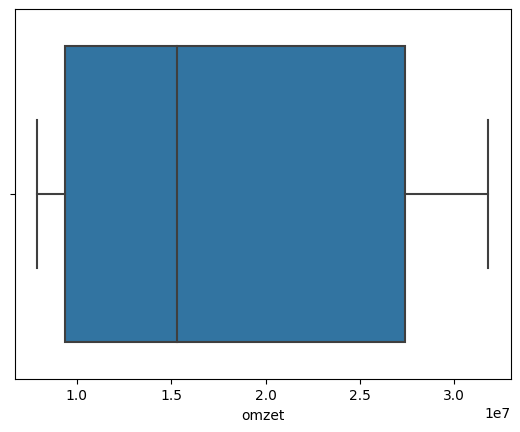

In [ ]:
sns.boxplot(data=df, x='omzet')

In [ ]:
X = df.drop(['general_score', 'environment','social','governance'], axis=1)
y = df['general_score']

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

numerical_ix = X.select_dtypes(include=['int32','int64','float64']).columns

col_transform = ColumnTransformer(transformers=[
    ('minmax',MinMaxScaler(), numerical_ix),
])

# Data-Analyse

<AxesSubplot:xlabel='environment', ylabel='Count'>

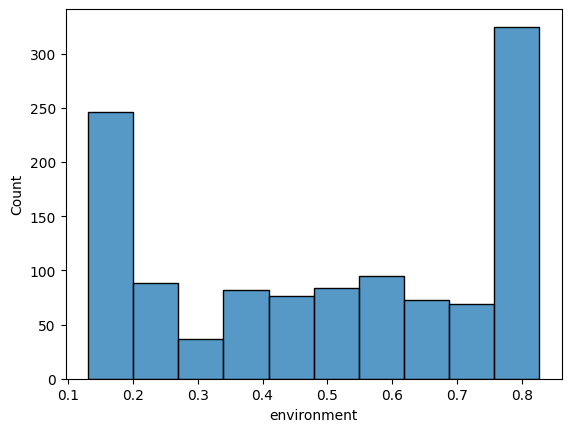

In [ ]:
import seaborn as sns
sns.histplot(data=df, x='environment', bins=10)

<AxesSubplot:xlabel='social', ylabel='Count'>

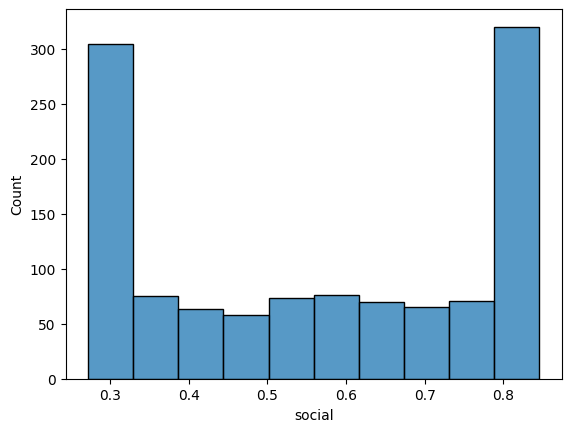

In [ ]:
sns.histplot(data=df, x='social', bins=10)

<AxesSubplot:xlabel='governance', ylabel='Count'>

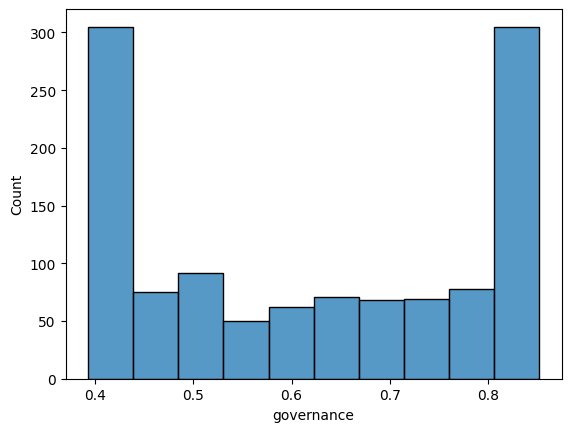

In [ ]:
sns.histplot(data=df, x='governance', bins=10)

<AxesSubplot:xlabel='omzet'>

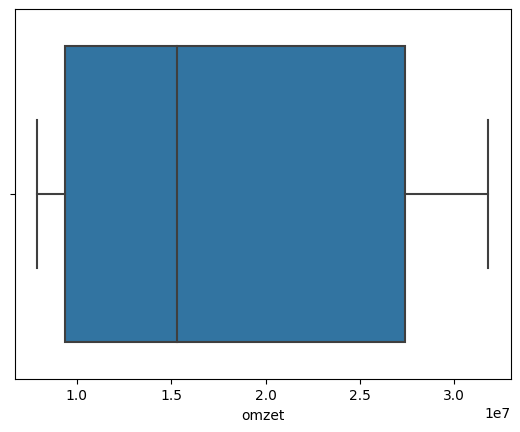

In [ ]:
sns.boxplot(data=df, x='omzet')

# Split

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Lineaire Regressie

In [ ]:
from sklearn.linear_model import LinearRegression

# Create the model
model = LinearRegression()

# Train the model using the training data
model.fit(X_train, y_train)

# Make predictions using the test data
predictions = model.predict(X_test)


In [ ]:
predictions

array([1.69022621, 1.65535359, 1.60681243, 1.62967393, 1.75677081,
       1.56936932, 1.69010935, 1.66285867, 1.63909509, 1.61540564,
       1.66276144, 1.64814252, 1.67189944, 1.66152508, 1.74378903,
       1.63963307, 1.73374293, 1.69373171, 1.65290981, 1.64781535,
       1.63474427, 1.7448514 , 1.67811149, 1.69420615, 1.69980748,
       1.69085175, 1.64875486, 1.77363913, 1.67916223, 1.61624324,
       1.66276144, 1.70853573, 1.73416946, 1.63794013, 1.73876425,
       1.66701179, 1.6752683 , 1.73376274, 1.77036139, 1.59785878,
       1.68140524, 1.69542504, 1.66285867, 1.62751382, 1.66282746,
       1.65511948, 1.6451496 , 1.66815422, 1.62628864, 1.63482729,
       1.66206391, 1.68800314, 1.73008335, 1.74280751, 1.66240106,
       1.63209918, 1.65200938, 1.64624895, 1.68463217, 1.76769559,
       1.72447911, 1.76685194, 1.71969901, 1.70091827, 1.65356289,
       1.70464968, 1.64063928, 1.63979806, 1.63669625, 1.60190631,
       1.64988363, 1.81831395, 1.67746524, 1.662742  , 1.79036

In [ ]:
# Print the model's coefficients and intercept
print(model.coef_)
print(model.intercept_)

[ 3.79017078e-02 -8.97059533e-10  3.20909342e-09  1.15418110e-03
  2.74040111e-03]
1.4503479282114609


In [310]:
from sklearn.metrics import mean_squared_error

# Compute the MSE for the model's predictions on the test set
mse = mean_squared_error(y_test, predictions)
print(f"MSE: {mse}")

from sklearn.metrics import r2_score

# Compute the R-squared for the model's predictions on the test set
r2 = r2_score(y_test, predictions)
print(f"R²: {r2}") # --> fit helemaal niet goed!

from sklearn.metrics import mean_absolute_error

# Compute the MAE for the model's predictions on the test set
mae = mean_absolute_error(y_test, predictions)
print(f"MAE: {mae}")

MSE: 0.20766994148339865
R²: 0.013346797444941494
MAE: 0.3795685282144157


# Decision Tree Regression

In [311]:
from sklearn.tree import DecisionTreeRegressor

# Create the model
model = DecisionTreeRegressor()

# Train the model using the training data
model.fit(X_train, y_train)

# Make predictions using the test data
predictions = model.predict(X_test)


In [312]:
from sklearn.metrics import mean_squared_error

# Compute the MSE for the model's predictions on the test set
mse = mean_squared_error(y_test, predictions)
print(f"MSE: {mse}")

from sklearn.metrics import r2_score

# Compute the R-squared for the model's predictions on the test set
r2 = r2_score(y_test, predictions)
print(f"R²: {r2}") # --> fit beter dan lineaire

from sklearn.metrics import mean_absolute_error

# Compute the MAE for the model's predictions on the test set
mae = mean_absolute_error(y_test, predictions)
print(f"MAE: {mae}")

MSE: 0.4071791462548239
R²: -0.9345342219305841
MAE: 0.5266606386979588
